In [3]:
import torch
import pandas as pd
from torch import nn
from torchvision import transforms

from functools import partial

from collections import defaultdict



import re, math, sys
import numpy as np
import random

import os
from tqdm import tqdm

from PIL import Image
import importlib

from matplotlib import pyplot as plt

# model specific


# BLIP-2 model

### Load data

In [4]:
stimuli_df = None
import utils
importlib.reload(utils)
stimuli_df = utils.STIMULI_DF

# add an extra "../" tot he data paths to create ../../VALSE_data
stimuli_df['img_path'] = [os.path.join("..",path) for path in stimuli_df['img_path']]

stimuli_df.head(2)


# import entire VALSE but only relevant linguistic phenomena
all_valse_df = utils.ENTIRE_DATASET_DF
all_valse_df = all_valse_df[all_valse_df['linguistic_phenomena'].isin(['actions','relations','existence'])]

# create 'img_path' column which has correct path to all the img files of valse dataset
all_valse_df['img_path'] = [os.path.join("../../VALSE_data/",path) for path in all_valse_df['local_img_path']]
all_valse_df.drop(['local_img_path'], axis=1)
all_valse_df.head(2)



/var/folders/3l/2lt99jp97mvbvsj3_p5hh8f80000gn/T/ipykernel_25367/1684243812.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_valse_df['img_path'] = [os.path.join("../../VALSE_data/",path) for path in all_valse_df['local_img_path']]


,dataset,dataset_idx,image_file,linguistic_phenomena,caption,answer,classes,split,original_split,classes_foil,...,key,declarative_statement,declarative_statement_foils,provenance_of_foils,foiling_method,orig_caption,only_caption,local_img_path,include_in_experiment,img_path
1000,coco2017,212732,000000462576.jpg,relations,Breakfast items including juice are on the table.,NaN,on,NaN,val,off,...,relations:coco_2017:212732,NaN,NaN,NaN,NaN,NaN,NaN,images/coco2017/000000462576.jpg,True,../../VALSE_data/images/coco2017/000000462576.jpg
1001,coco2017,528685,000000294162.jpg,relations,The white laptop is turned off but left open.,NaN,off,NaN,val,on,...,relations:coco_2017:528685,NaN,NaN,NaN,NaN,NaN,NaN,images/coco2017/000000294162.jpg,True,../../VALSE_data/images/coco2017/000000294162.jpg


### Load model

In [6]:
global model
import requests
from transformers import Blip2Processor, Blip2Model
 
model = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base")
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2Model.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
model.to(device)

model_name = "BLIP-2"

Some weights of the model checkpoint at Salesforce/blip-image-captioning-base were not used when initializing BlipModel: ['text_decoder.bert.encoder.layer.2.attention.self.query.weight', 'text_decoder.bert.encoder.layer.8.crossattention.output.LayerNorm.bias', 'text_decoder.bert.encoder.layer.4.crossattention.self.value.weight', 'text_decoder.bert.encoder.layer.3.crossattention.output.dense.weight', 'text_decoder.bert.encoder.layer.2.output.LayerNorm.weight', 'text_decoder.bert.encoder.layer.8.crossattention.self.value.weight', 'text_decoder.bert.encoder.layer.5.attention.self.key.bias', 'text_decoder.bert.encoder.layer.3.attention.output.dense.bias', 'text_decoder.bert.encoder.layer.6.crossattention.output.LayerNorm.weight', 'text_decoder.bert.encoder.layer.9.crossattention.self.value.bias', 'text_decoder.bert.encoder.layer.0.attention.output.LayerNorm.bias', 'text_decoder.bert.encoder.layer.4.attention.self.key.weight', 'text_decoder.bert.encoder.layer.10.attention.self.query.bias', 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
processor

BlipProcessor:
- image_processor: BlipImageProcessor {
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "BlipImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "BlipProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

- tokenizer: BertTokenizerFast(name_or_path='Salesforce/blip-image-captioning-base', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

# Test model

Caption: There is at least one bike on the rack.
Foil: There are no bikes on the rack.


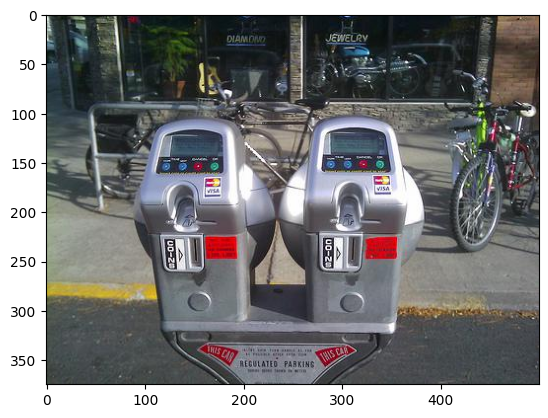

In [5]:
row = stimuli_df.iloc[7]
img_path, caption, foil = row['img_path'], row['caption'], row['foil']
image = Image.open(img_path)

plt.imshow(image)
print(f"Caption: {caption}\nFoil: {foil}")




### Inspect processing

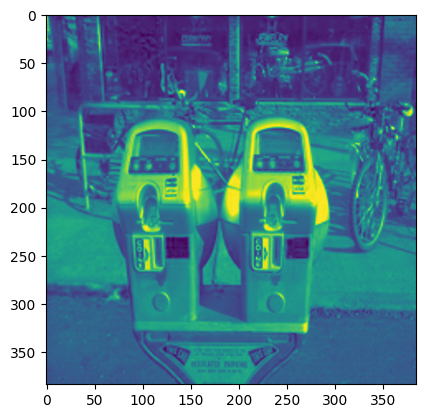

In [23]:
processed = processor(text=["Bike"],
                      images = [image.resize((224,224))],
                      return_tensors = 'pt',
                      padding=True
                      )

plt.imshow(processed['pixel_values'][0][-1, :,:])

# Run on data

### Define model prediction function (for SHAP -- taking list of images and caption/foil as input)

In [24]:
text_out = []

def model_predict(images, caption, foil, single_image = False, single_score = True):


    """Needs CAPTION and FOIL to be defined outside the function,
    they are kept constant within the function

    images needs to be a LIST, even if only one member
    

    single score = True for SHAP! (this means one number returned for each image)
    single_image = False for SHAP! (single_image means only one value or set of values is returned, assuming there is 1 image only)
    (do not set single_image to true if there are multiple images)
    """

    global model

    processed = processor(text = [caption, foil],
                          images = images,
                          return_tensors = 'pt',
                          padding = True
                          )
    
    text_out.append(f"Processing SHAP with {caption} and {foil}")
    
    with torch.no_grad():
        outputs = model(**processed).logits_per_image # generatre logits for caption and foil for each image
        # Assuming the first score is for caption and second for foil

        # if a single score, return a single score for each image (for SHAP)
        if single_score:
            outputs = outputs[:, 0] - outputs[:, 1]  

        # if single image=True, return the first element of the list of instead of a list of outputs
        if single_image:
            return outputs[0].numpy()
        else: # otherwise return a list
            return outputs.numpy()


model_predict([image, image, image], caption, foil, single_image = False, single_score = False)

array([[0.1376052, 0.2194616],
       [0.1376052, 0.2194616],
       [0.1376052, 0.2194616]], dtype=float32)

### Define function: model output caption for dataframes (taking dataframe as input)

Difference: the SHAP prediction function works with a list of images for a single set of captions. 

This one works with a dataframe where each SINGLE image is paired with one caption/foil and an output generated.

In [15]:
def model_output_dataframe(df):
    
    """Given a dataframe of images, captions, and foils, returns a dataframe of model outputs, one for each row in the dataframe"""

    results = defaultdict(list)

    for _, row in tqdm(df.iterrows()):

        # copy over those things that should be copied directly
        for name in ["img_path", "caption", "foil", "linguistic_phenomena"]:
            results[name].append(row[name])

        # prepare data point as inputs to test model on
        image = Image.open(row["img_path"])
        image = image.resize((224,224))

        caption, foil = row["caption"], row["foil"]
        
        
        # create model input with BOTH captions
        try:
            model_results = model_predict([image], caption, foil, single_image = True, single_score = False)
        except Exception as e:
            print(f"Trouble processing {row['img_path']}")
            print(e)
            continue
        
        caption_score, foil_score = model_results[0].item(), model_results[1].item()
        caption_foil_diff = caption_score - foil_score
        
        # save relevant fields to the dictionary to either {caption} or {foil} (based on which it is)
        results["model_pred_caption"].append(caption_score) # logit
        results["model_pred_foil"].append(foil_score)
        results["model_pred_diff"].append(caption_foil_diff)
    
    model_output = pd.DataFrame.from_dict(results)

    print(results)

    return model_output

### Generate model output for each data point in STIMULI dataframe (without maskng)

99it [00:32,  3.08it/s]

defaultdict(<class 'list'>, {'img_path': ['../../VALSE_data/images/v7w/v7w_2318073.jpg', '../../VALSE_data/images/v7w/v7w_2323857.jpg', '../../VALSE_data/images/v7w/v7w_2336798.jpg', '../../VALSE_data/images/v7w/v7w_2349587.jpg', '../../VALSE_data/images/v7w/v7w_2352298.jpg', '../../VALSE_data/images/v7w/v7w_2360434.jpg', '../../VALSE_data/images/v7w/v7w_2362476.jpg', '../../VALSE_data/images/v7w/v7w_2389519.jpg', '../../VALSE_data/images/v7w/v7w_2393355.jpg', '../../VALSE_data/images/v7w/v7w_2411942.jpg', '../../VALSE_data/images/v7w/v7w_2417412.jpg', '../../VALSE_data/images/swig/speaking_84.jpg', '../../VALSE_data/images/swig/tripping_125.jpg', '../../VALSE_data/images/swig/punching_28.jpg', '../../VALSE_data/images/swig/handcuffing_40.jpg', '../../VALSE_data/images/swig/caressing_51.jpg', '../../VALSE_data/images/swig/urinating_251.jpg', '../../VALSE_data/images/swig/foraging_17.jpg', '../../VALSE_data/images/swig/communicating_34.jpg', '../../VALSE_data/images/swig/complaining_6.j

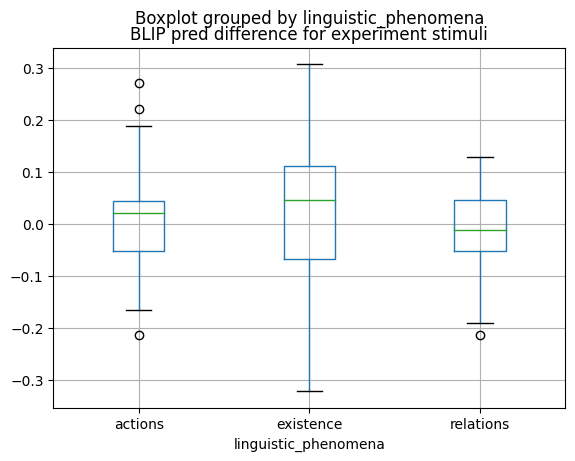

In [17]:

stimuli_output_df = model_output_dataframe(stimuli_df)

# export results
stimuli_output_df.to_pickle(f"xai_output/{model_name}_stimuli_output_scores.pickle")

# graph outcome
stimuli_output_df.boxplot(column='model_pred_diff', by='linguistic_phenomena')
plt.title(f"{model_name} pred difference for experiment stimuli")
plt.show()


### Generate model output for ENTIRE VALSE DATASET for 3 linguistic phenomena

Assuming  only for 3 phenomena

2637it [13:54,  3.16it/s]

defaultdict(<class 'list'>, {'img_path': ['../../VALSE_data/images/coco2017/000000462576.jpg', '../../VALSE_data/images/coco2017/000000294162.jpg', '../../VALSE_data/images/coco2017/000000144333.jpg', '../../VALSE_data/images/coco2017/000000181666.jpg', '../../VALSE_data/images/coco2017/000000482436.jpg', '../../VALSE_data/images/coco2017/000000153299.jpg', '../../VALSE_data/images/coco2017/000000337055.jpg', '../../VALSE_data/images/coco2017/000000526728.jpg', '../../VALSE_data/images/coco2017/000000402519.jpg', '../../VALSE_data/images/coco2017/000000490413.jpg', '../../VALSE_data/images/coco2017/000000178618.jpg', '../../VALSE_data/images/coco2017/000000140286.jpg', '../../VALSE_data/images/coco2017/000000033368.jpg', '../../VALSE_data/images/coco2017/000000034760.jpg', '../../VALSE_data/images/coco2017/000000320554.jpg', '../../VALSE_data/images/coco2017/000000141671.jpg', '../../VALSE_data/images/coco2017/000000068628.jpg', '../../VALSE_data/images/coco2017/000000003255.jpg', '../

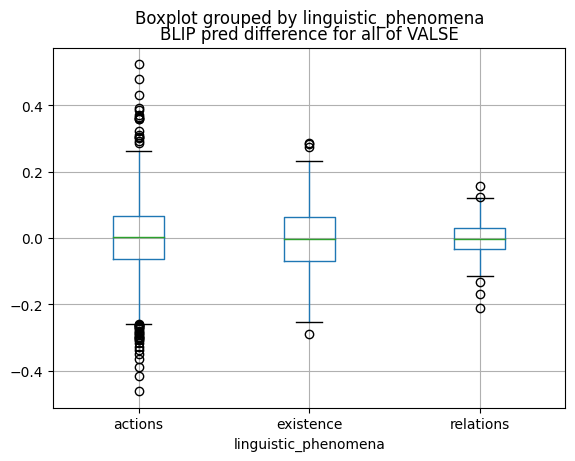

In [7]:
RUN_ON_WHOLE_DATASET = True # can be turned off when we don't need this

if RUN_ON_WHOLE_DATASET:

    valse_output_df = model_output_dataframe(all_valse_df)

    # export results
    valse_output_df.to_pickle(f"xai_output/{model_name}_all_of_valse_output_scores.pickle")

    # graph outcome
    valse_output_df.boxplot(column='model_pred_diff', by='linguistic_phenomena')
    plt.title(f"{model_name} pred difference for all of VALSE")
    plt.show()

## Build SHAP pipeline

### Test masking

In [29]:
# from shap_functions import vector_to_masked_images, blur_image

# image = Image.open("../../VALSE_data/images/coco2017/000000122672.jpg")
# image = np.array(image.resize((224,224)))

# blurred_image = blur_image(image)

# test_mask_array = np.array([
#     [1, 0, 0, 1],
#     [0, 1, 1, 0],
#     [1, 0, 0, 0],
#     [0, 0, 1, 0]
# ])

# masked_img = vector_to_masked_images([test_mask_array], image, blurred_image, N_ROWS=4)[0]
# plt.imshow(masked_img)

### SHAP function

In [11]:
import shap_functions
importlib.reload(shap_functions)

<module 'shap_functions' from '/Users/eduardsaakashvili/Desktop/UU/Thesis/code/es-thesis-repo/data/xai_maps/shap_functions.py'>

# Generate and export SHAP maps

### Generate maps

In [ ]:

VERBOSE = 1 
DISPLAY_PLOTS = False
EXPORT_PLOTS = True

output = defaultdict(list)

for index, row in stimuli_df.iterrows():

    # note that if index is not reset this will go 1 to 33 three times.
    print(f"Processing stimulus {index+1} out of {len(stimuli_df)}")

    # copy main characteristics
    for name in ["img_path", "caption", "foil", "linguistic_phenomena"]:
        output[name].append(row[name])

    # calcualte shap map
    try:
        shap_map, n_variants = shap_functions.generate_shap(row['img_path'], row['caption'], row['foil'],
                                        prediction_function=model_predict,
                                        model = model,
                                        model_name = model_name,
                                        verbose = VERBOSE,
                                        plots = DISPLAY_PLOTS,
                                        export_plots = EXPORT_PLOTS,
                                        return_variant_count = True)
        
        output["model_shap_map"].append(shap_map)
        output['n_image_variants'].append(n_variants)

    except Exception as e:
         output['model_shap_map'].append("Error: "+str(e))
    1
final_model_shap_df = pd.DataFrame.from_dict(output)
    

In [13]:
final_model_shap_df

,img_path,caption,foil,linguistic_phenomena,model_shap_map,n_image_variants
0,../../VALSE_data/images/v7w/v7w_2318073.jpg,There is at least one light.,There are no lights.,existence,"[[0.005013522692024708, -0.018415904603898525,...",172


In [27]:
for key in output.keys():
    print(key, len(output[key]))

img_path 1
caption 1
foil 1
linguistic_phenomena 1
model_shap_map 1


### Export resulting dataframe

In [52]:
final_model_shap_df.to_pickle(f"xai_output/{model_name}_shap_maps.pickle")

### Find which if any stimuli threw an error

In [53]:
final_model_shap_df[final_model_shap_df['model_shap_map'].apply(isinstance, args=(str,))]

,img_path,caption,foil,linguistic_phenomena,model_shap_map


In [35]:
plt.imshow(final_clip_shap_df['clip_shap_map'][0])

NameError: name 'final_clip_shap_df' is not defined